In [24]:
import numpy as np
import pandas as pd
from eodhd import APIClient
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
import re
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import lightgbm as lgb
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

## 1. Gathering news headlines

In [25]:
def collect_financial_news(api_key, stock_symbols, from_date, to_date, limit=100):
    client = APIClient(api_key)
    all_news_df = pd.DataFrame()
    
    for symbol in stock_symbols:
        resp = client.financial_news(s=symbol, from_date=from_date, to_date=to_date, limit=limit)
        news_df = pd.DataFrame(resp)
        news_df['symbol'] = symbol  # Aggiungi una colonna per identificare l'azione
        all_news_df = pd.concat([all_news_df, news_df], ignore_index=True)
    
    return all_news_df

In [26]:
def clean_text(text):
    # Rimozione di punteggiatura, ma mantenendo i numeri e i simboli percentuali
    text = re.sub(r'[^\w\s%]', '', text)
    # Conversione in minuscolo
    text = text.lower()
    # Rimozione di spazi extra
    text = re.sub(r'\s+', ' ', text).strip()
    return text

## 2. Sentiment analysis

In [27]:
def preprocess_and_analyze_news(news_df):
    # Inizializza l'analizzatore VADER
    vader_analyzer = SentimentIntensityAnalyzer()

    # Pulizia dei titoli delle notizie
    news_df['cleaned_title'] = news_df['title'].apply(clean_text)
    
    # Calcolo del sentiment dei titoli delle notizie usando TextBlob
    news_df['sentiment_textblob'] = news_df['cleaned_title'].apply(lambda x: TextBlob(x).sentiment.polarity)
    
    # Calcolo del sentiment dei titoli delle notizie usando VADER
    news_df['sentiment_vader'] = news_df['cleaned_title'].apply(lambda x: vader_analyzer.polarity_scores(x)['compound'])
    
    # Conversione titoli delle notizie in TF-IDF
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(news_df['cleaned_title'])
    
    # Sentimenti come caratteristiche aggiuntive
    X = scipy.sparse.hstack((X, news_df[['sentiment_textblob', 'sentiment_vader']].values))
    
    return news_df, X, vectorizer

In [28]:
def filter_weekend_news(news_df):
    news_df.loc[:, 'weekday'] = pd.to_datetime(news_df['date']).dt.weekday
    # Si mantengono solo i giorni dal lunedì al venerdì
    filtered_news_df = news_df[news_df['weekday'] < 5].copy()
    filtered_news_df.drop(columns=['weekday'], inplace=True)
    return filtered_news_df

In [29]:
api_key = '665456c26be9a2.11369205'
stock_symbols = ["AAPL.US", "MSFT.US", "GOOGL.US"]
from_date = '2024-01-01'
to_date = '2024-01-30'

all_news_df = collect_financial_news(api_key, stock_symbols, from_date, to_date)

In [8]:
filtered_news_df = filter_weekend_news(all_news_df)
news_df, X, vectorizer = preprocess_and_analyze_news(filtered_news_df)
news_df.head()

,date,title,content,link,symbols,tags,sentiment,symbol,cleaned_title,sentiment_textblob,sentiment_vader
0,2024-01-30T22:24:05+00:00,"Dow Jones Futures: Microsoft, Google, AMD Fall...","Microsoft, Google and AMD earnings are a big t...",https://finance.yahoo.com/m/c78e3618-8015-3089...,"[0QYP.IL, 0R2V.IL, 0RIH.IL, A1MD34.SA, AAPL.BA...",[],"{'polarity': -0.026, 'neg': 0.127, 'neu': 0.78...",AAPL.US,dow jones futures microsoft google amd fall on...,-0.30000000,-0.40190000
1,2024-01-30T21:29:00+00:00,"Top Stock Reports for Apple, Visa &amp; Novo N...","Tuesday, January 30, 2024\r\n\r\nThe Zacks Res...",https://finance.yahoo.com/news/top-stock-repor...,"[0R2V.IL, 3V6.F, 3V64.F, 3V64.STU, 3V64.XETRA,...",[],"{'polarity': 1, 'neg': 0.02, 'neu': 0.796, 'po...",AAPL.US,top stock reports for apple visa amp novo nordisk,0.50000000,0.20230000
2,2024-01-30T21:23:18+00:00,3 Must-Watch Stocks Just as Unstoppable as Nvidia,Nvidia (NASDAQ:NVDA) remains one of the hottes...,https://finance.yahoo.com/news/3-must-watch-st...,"[0I47.LSE, 0R2L.LSE, AAPL.US, BERK34.SA, BRH.B...",[],"{'polarity': 0.998, 'neg': 0.023, 'neu': 0.841...",AAPL.US,3 mustwatch stocks just as unstoppable as nvidia,0.00000000,-0.20230000
3,2024-01-30T20:24:00+00:00,Apple Stock Sags as Analyst Forecasts Big Drop...,“Apple may have the most significant decline a...,https://finance.yahoo.com/m/1e001ea3-7d8f-3159...,"[0R2V.IL, AAPL.BA, AAPL.MX, AAPL.NEO, AAPL.SN,...",[],"{'polarity': 0.265, 'neg': 0, 'neu': 0.918, 'p...",AAPL.US,apple stock sags as analyst forecasts big drop...,0.00000000,-0.27320000
4,2024-01-30T19:56:22+00:00,Wall Street Favorites: 3 AI Stocks With Strong...,AI stocks are surging ahead with unprecedented...,https://finance.yahoo.com/news/wall-street-fav...,"[2330.TW, 9888.HK, AAPL.US, ACLS.US, B1C.F, B1...",[],"{'polarity': 0.999, 'neg': 0.012, 'neu': 0.818...",AAPL.US,wall street favorites 3 ai stocks with strong ...,0.43333333,0.72690000


In [30]:
def plot_sentiment_distribution(news_df):
    plt.figure(figsize=(12, 6))
    sns.histplot(news_df['sentiment_textblob'], kde=True, color='blue', label='TextBlob')
    sns.histplot(news_df['sentiment_vader'], kde=True, color='green', label='VADER')
    plt.title('Distribuzione dei Sentimenti')
    plt.xlabel('Sentiment')
    plt.ylabel('Frequenza')
    plt.legend()
    plt.show()

In [31]:
def plot_average_sentiment_per_stock(news_df):
    avg_sentiment = news_df.groupby('symbol')[['sentiment_textblob', 'sentiment_vader']].mean().reset_index()
    avg_sentiment = pd.melt(avg_sentiment, id_vars=['symbol'], value_vars=['sentiment_textblob', 'sentiment_vader'], 
                            var_name='Sentiment Type', value_name='Sentiment Score')
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=avg_sentiment, x='symbol', y='Sentiment Score', hue='Sentiment Type')
    plt.title('Sentimento Medio per Azione')
    plt.xlabel('Azione')
    plt.ylabel('Sentiment Medio')
    plt.legend()
    plt.show()

In [32]:
def plot_sentiment_over_time(news_df, stock_symbols):
    news_df['date'] = pd.to_datetime(news_df['date'])
    
    num_stocks = len(stock_symbols)
    cols = 2
    rows = (num_stocks // cols) + (num_stocks % cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), sharex=True, sharey=True)
    axes = axes.flatten()
    
    for i, symbol in enumerate(stock_symbols):
        stock_news = news_df[news_df['symbol'] == symbol].set_index('date')
        stock_news = stock_news[['sentiment_textblob', 'sentiment_vader']].resample('D').mean().reset_index()
        
        axes[i].plot(stock_news['date'], stock_news['sentiment_textblob'], label='TextBlob', color='blue')
        axes[i].plot(stock_news['date'], stock_news['sentiment_vader'], label='VADER', color='green')
        axes[i].set_title(f'Sentiment Over Time for {symbol}')
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('Sentiment')
        axes[i].legend()
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

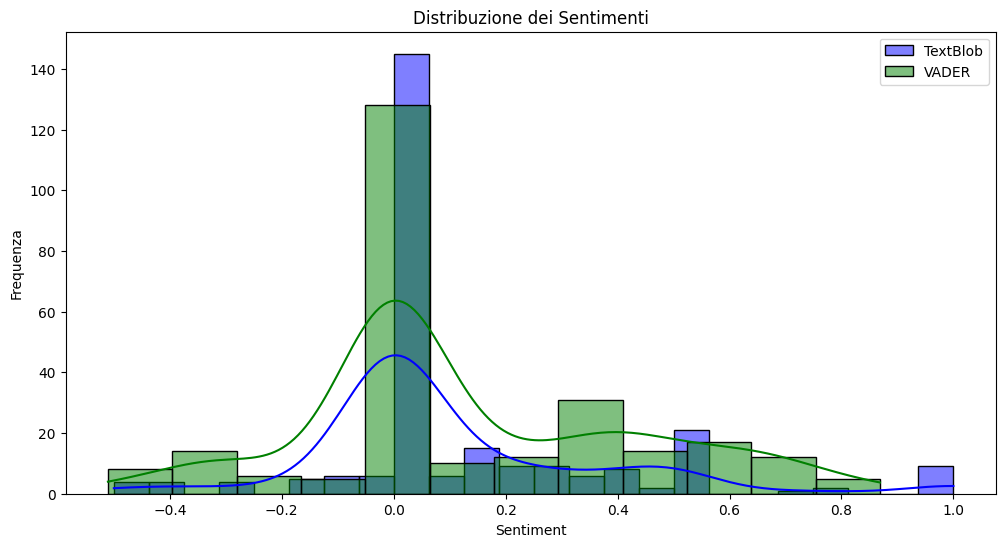

In [33]:
plot_sentiment_distribution(news_df)

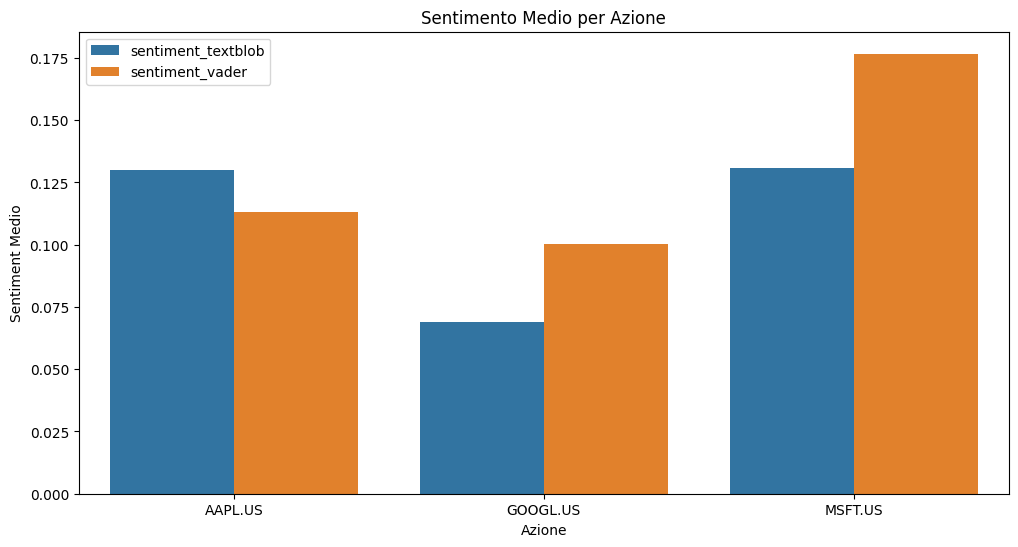

In [34]:
plot_average_sentiment_per_stock(news_df)

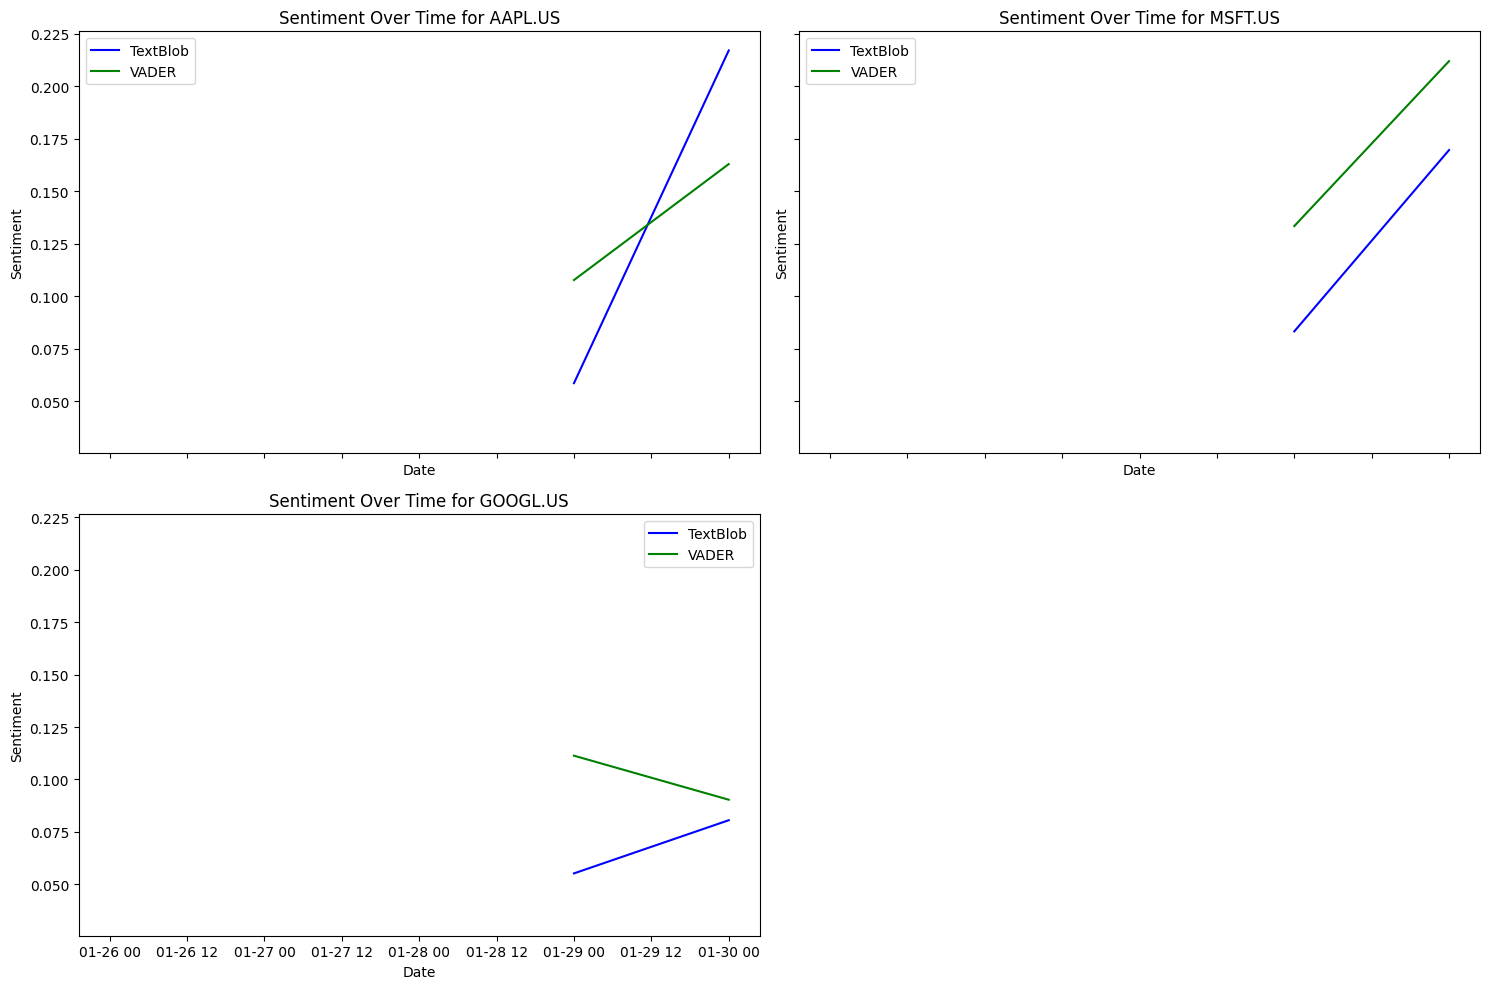

In [35]:
plot_sentiment_over_time(news_df, stock_symbols)

## 3. Gathering financial information

In [36]:
def collect_stock_prices_yfinance(stock_symbols, from_date, to_date):
    all_prices_df = pd.DataFrame()
    for symbol in stock_symbols:
        stock_symbol = symbol.split('.')[0]  # Rimuovere il suffisso ".US"
        stock_data = yf.download(stock_symbol, start=from_date, end=to_date)
        stock_data['symbol'] = symbol  # Riaggiungere il suffisso ".US"
        stock_data.reset_index(inplace=True)
        all_prices_df = pd.concat([all_prices_df, stock_data], ignore_index=True)
    return all_prices_df

In [37]:
def calculate_price_changes(prices_df):
    prices_df['Date'] = pd.to_datetime(prices_df['Date'])
    prices_df = prices_df.sort_values(by=['symbol', 'Date'])
    # prices_df['price_change'] = prices_df.groupby('symbol')['Close'].pct_change()
    prices_df['price_change'] = prices_df.groupby('symbol')['Close'].diff()
    return prices_df

In [38]:
def merge_news_and_prices(news_df, prices_df):
    news_df['date'] = pd.to_datetime(news_df['date']).dt.date
    prices_df['Date'] = pd.to_datetime(prices_df['Date']).dt.date
    
    # Identificazione delle date mancanti
    missing_dates = set(news_df['date'].unique()) - set(prices_df['Date'].unique())
    print("Date mancanti nei dati finanziari:", missing_dates)
    
    # Filtra le notizie per escludere le date mancanti
    news_df = news_df[~news_df['date'].isin(missing_dates)]
    
    merged_df = pd.merge(news_df, prices_df, left_on=['symbol', 'date'], right_on=['symbol', 'Date'])
    return merged_df

In [39]:
all_prices_df = collect_stock_prices_yfinance(stock_symbols, from_date, to_date)
all_prices_df.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume,symbol
0,2024-01-02,187.14999390,188.44000244,183.88999939,185.63999939,185.15228271,82488700,AAPL.US
1,2024-01-03,184.22000122,185.88000488,183.42999268,184.25000000,183.76594543,58414500,AAPL.US
2,2024-01-04,182.14999390,183.08999634,180.88000488,181.91000366,181.43209839,71983600,AAPL.US
3,2024-01-05,181.99000549,182.75999451,180.16999817,181.17999268,180.70399475,62303300,AAPL.US
4,2024-01-08,182.08999634,185.60000610,181.50000000,185.55999756,185.07249451,59144500,AAPL.US


In [40]:
# Calcolo delle variazioni di prezzo
all_prices_df = calculate_price_changes(all_prices_df)
all_prices_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,symbol,price_change
0,2024-01-02,187.14999390,188.44000244,183.88999939,185.63999939,185.15228271,82488700,AAPL.US,NaN
1,2024-01-03,184.22000122,185.88000488,183.42999268,184.25000000,183.76594543,58414500,AAPL.US,-1.38999939
2,2024-01-04,182.14999390,183.08999634,180.88000488,181.91000366,181.43209839,71983600,AAPL.US,-2.33999634
3,2024-01-05,181.99000549,182.75999451,180.16999817,181.17999268,180.70399475,62303300,AAPL.US,-0.73001099
4,2024-01-08,182.08999634,185.60000610,181.50000000,185.55999756,185.07249451,59144500,AAPL.US,4.38000488


## 4. Merge News Headlines + Financial Information

In [41]:
# Fusione dei dati delle notizie e dei prezzi
merged_df = merge_news_and_prices(news_df, all_prices_df)
merged_df.head()

Date mancanti nei dati finanziari: {datetime.date(2024, 1, 30)}


,date,title,content,link,symbols,tags,sentiment,symbol,cleaned_title,sentiment_textblob,sentiment_vader,Date,Open,High,Low,Close,Adj Close,Volume,price_change
0,2024-01-29,Dow Jones Futures: Fed Meeting On Deck; AI Sto...,Dow Jones futures: The stock market surged Mon...,https://finance.yahoo.com/m/2ce7ff9a-a235-3445...,"[0R2V.IL, AAPL.BA, AAPL.MX, AAPL.NEO, AAPL.SN,...",[],"{'polarity': 0, 'neg': 0, 'neu': 1, 'pos': 0}",AAPL.US,dow jones futures fed meeting on deck ai stock...,0.00000000,0.00000000,2024-01-29,192.00999451,192.19999695,189.58000183,191.72999573,191.22628784,47145600,-0.69000244
1,2024-01-29,LeddarTech's Board of Directors Appoints Sylvi...,"QUEBEC CITY, Jan. 30, 2024 /PRNewswire/ -- Led...",https://finance.yahoo.com/news/leddartechs-boa...,"[0RT6.LSE, AAPL.US, BEN.US, FRK.DU, FRK.F, FRK...",[],"{'polarity': 0.969, 'neg': 0.051, 'neu': 0.859...",AAPL.US,leddartechs board of directors appoints sylvie...,0.00000000,0.00000000,2024-01-29,192.00999451,192.19999695,189.58000183,191.72999573,191.22628784,47145600,-0.69000244
2,2024-01-29,Apple Q1 Earnings: Key Metrics to Watch,"It’s a highly critical week for earnings, with...",https://finance.yahoo.com/news/apple-q1-earnin...,"[AAPL.MX, AAPL.US, AAPL34.SA, APC.F, APC.XETRA]",[],"{'polarity': 0.995, 'neg': 0.021, 'neu': 0.861...",AAPL.US,apple q1 earnings key metrics to watch,0.00000000,0.00000000,2024-01-29,192.00999451,192.19999695,189.58000183,191.72999573,191.22628784,47145600,-0.69000244
3,2024-01-29,Stocks Pick Up Afternoon Steam To End At Day's...,All three major indexes rallied to close at th...,https://finance.yahoo.com/m/99c9819a-8c93-3126...,"[A1MD34.SA, AAPL.MX, AAPL.US, AAPL34.SA, ABEA....",[],"{'polarity': 0.649, 'neg': 0.013, 'neu': 0.92,...",AAPL.US,stocks pick up afternoon steam to end at days ...,0.13636364,0.00000000,2024-01-29,192.00999451,192.19999695,189.58000183,191.72999573,191.22628784,47145600,-0.69000244
4,2024-01-29,Paddy Power owner plans to quit FTSE 100 in fr...,Flutter has said it will make New York its pri...,https://uk.finance.yahoo.com/news/paddy-power-...,"[0HC3.LSE, 0RYA.IL, 3333.HK, AAPL.MX, AAPL.US,...",[],"{'polarity': 0.999, 'neg': 0.087, 'neu': 0.808...",AAPL.US,paddy power owner plans to quit ftse 100 in fr...,0.30000000,0.31820000,2024-01-29,192.00999451,192.19999695,189.58000183,191.72999573,191.22628784,47145600,-0.69000244


In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Analisi descrittiva
def analyze_dataset(df):
    print("Dataset Info:")
    print(df.info())
    print("\nSummary Statistics:")
    print(df.describe())
    print("\nMissing Values:")
    print(df.isnull().sum())

# Grafico della distribuzione delle etichette
def plot_label_distribution(df):
    plt.figure(figsize=(8, 6))
    sns.countplot(x='label', data=df)
    plt.title('Distribuzione delle Etichette')
    plt.xlabel('Etichetta')
    plt.ylabel('Conteggio')
    plt.show()

# Grafico delle variazioni di prezzo
def plot_price_changes(df):
    plt.figure(figsize=(10, 6))
    sns.histplot(df['price_change'], bins=20, kde=True)
    plt.title('Distribuzione delle Variazioni di Prezzo')
    plt.xlabel('Variazione di Prezzo')
    plt.ylabel('Frequenza')
    plt.show()

# Grafico della relazione tra sentiment e variazioni di prezzo
def plot_sentiment_vs_price_change(df):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='sentiment_textblob', y='price_change', data=df, hue='label')
    plt.title('Relazione tra Sentiment e Variazioni di Prezzo')
    plt.xlabel('Sentiment (TextBlob)')
    plt.ylabel('Variazione di Prezzo')
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='sentiment_vader', y='price_change', data=df, hue='label')
    plt.title('Relazione tra Sentiment e Variazioni di Prezzo')
    plt.xlabel('Sentiment (VADER)')
    plt.ylabel('Variazione di Prezzo')
    plt.show()

def plot_correlation_matrix(df):
    plt.figure(figsize=(12, 10))
    
    # Seleziona solo le colonne numeriche
    numeric_df = df.select_dtypes(include=[np.number])
    
    correlation_matrix = numeric_df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Matrice di Correlazione')
    plt.show()

In [60]:
# Analizza il dataset
analyze_dataset(merged_df)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                131 non-null    object 
 1   title               131 non-null    object 
 2   content             131 non-null    object 
 3   link                131 non-null    object 
 4   symbols             131 non-null    object 
 5   tags                131 non-null    object 
 6   sentiment           131 non-null    object 
 7   symbol              131 non-null    object 
 8   cleaned_title       131 non-null    object 
 9   sentiment_textblob  131 non-null    float64
 10  sentiment_vader     131 non-null    float64
 11  Date                131 non-null    object 
 12  Open                131 non-null    float64
 13  High                131 non-null    float64
 14  Low                 131 non-null    float64
 15  Close               131 non-null    float64

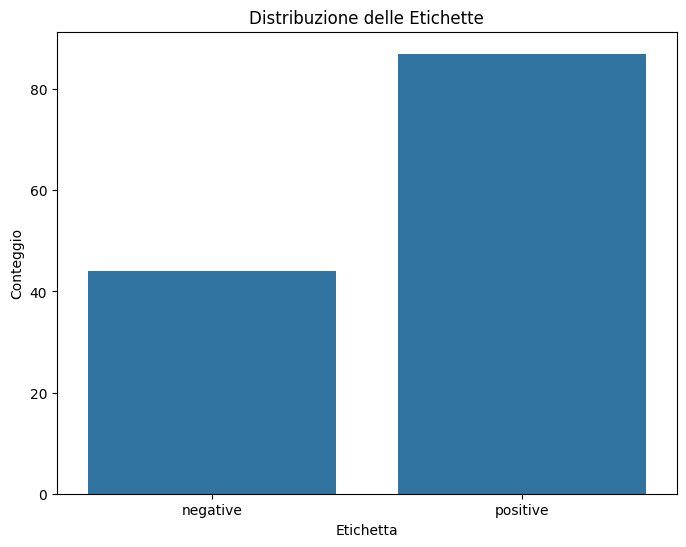

In [61]:
# Visualizza la distribuzione delle etichette
plot_label_distribution(merged_df)

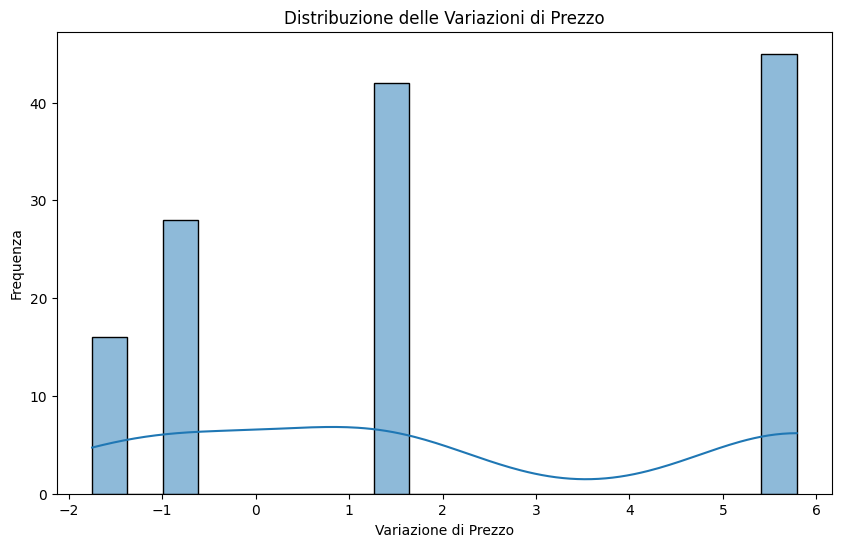

In [62]:
# Visualizza la distribuzione delle variazioni di prezzo
plot_price_changes(merged_df)

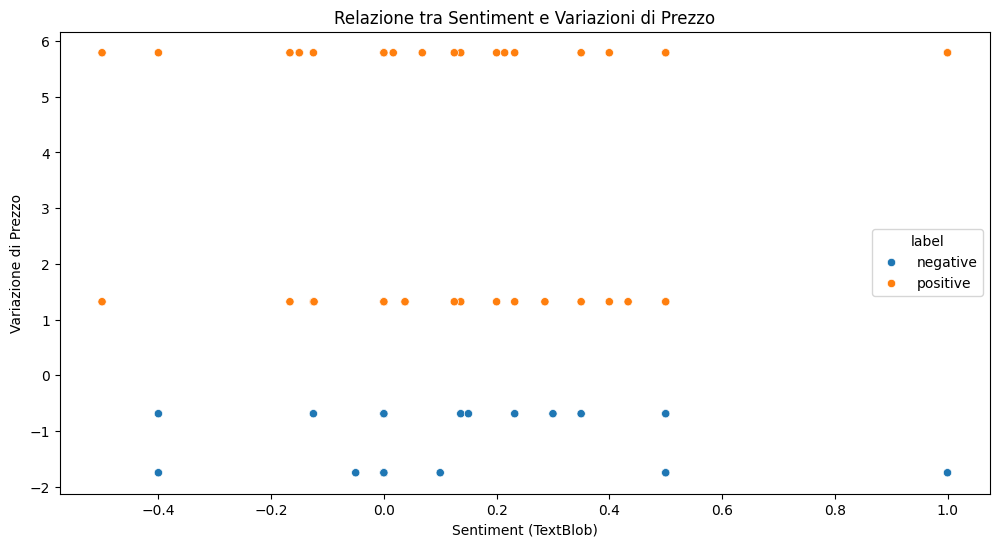

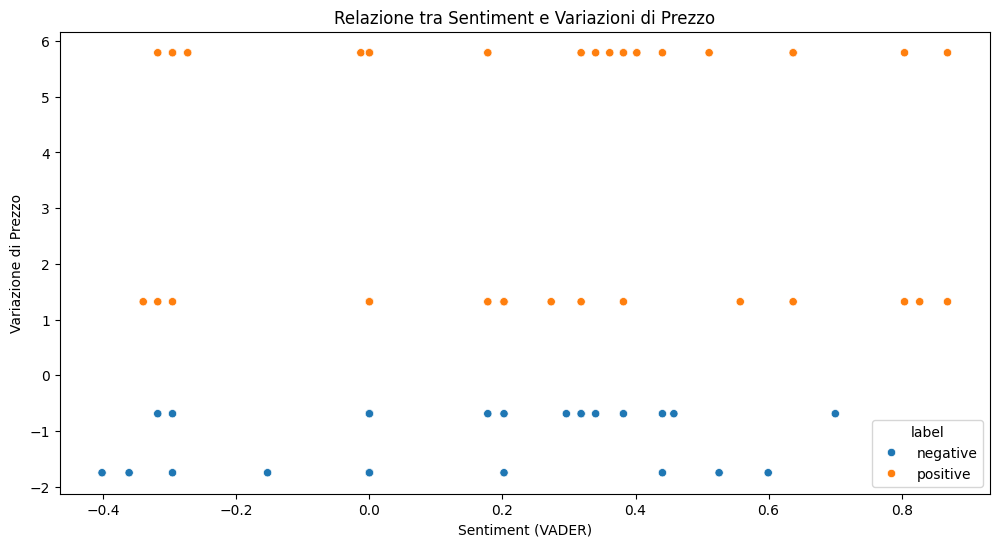

In [63]:
# Visualizza la relazione tra sentiment e variazioni di prezzo
plot_sentiment_vs_price_change(merged_df)

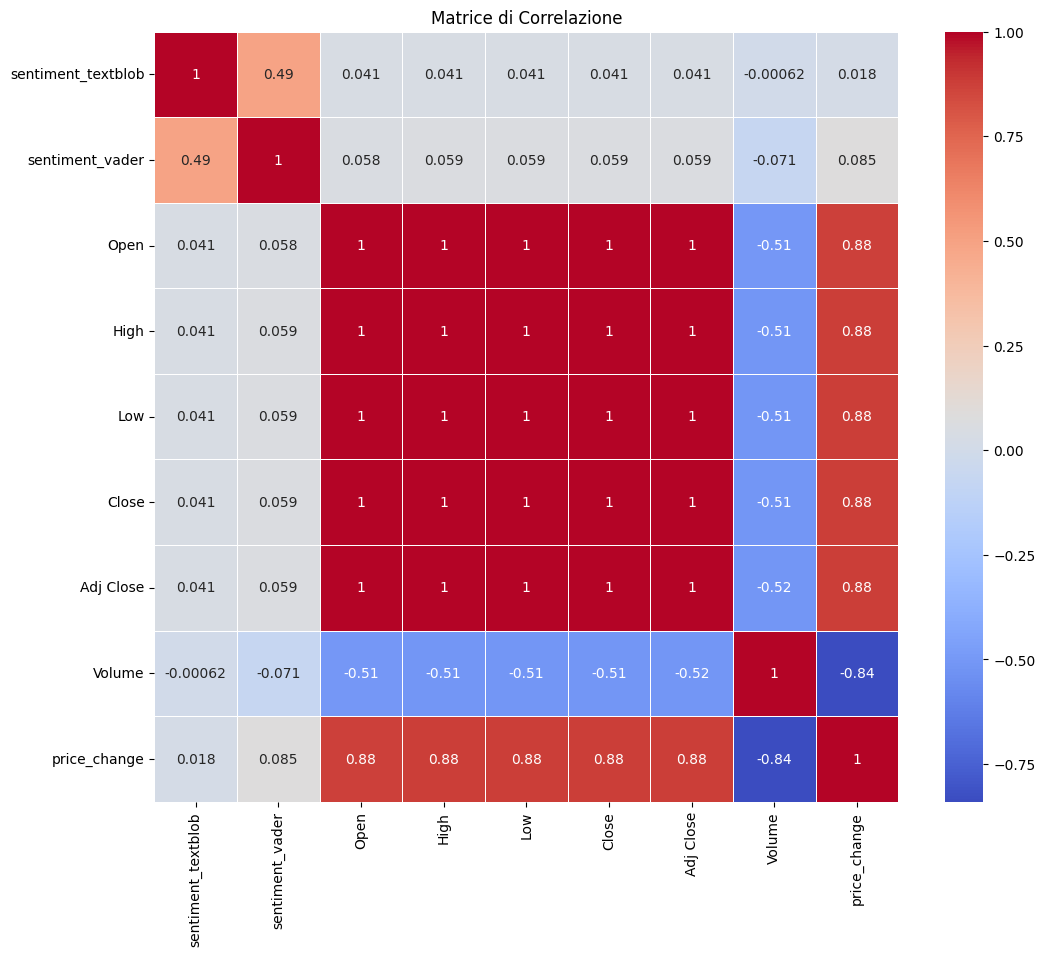

In [66]:
# Visualizza la matrice di correlazione
plot_correlation_matrix(merged_df)

## 5. Tags Classification

In [57]:
## Creazione delle Label con Tre Classi Basate su una Soglia
threshold = 0.005  # Abbassa il threshold per catturare più variazioni insignificanti
merged_df['label'] = np.select(
    [
        (merged_df['price_change'] > threshold),  # Variazione positiva significativa
        (merged_df['price_change'] < -threshold)  # Variazione negativa significativa
    ],
    [
        'positive',
        'negative'
    ],
    default='no_change'
)

# Controlla il bilanciamento delle etichette
print(merged_df['label'].value_counts())  # Verifica delle etichette

label
positive    87
negative    44
Name: count, dtype: int64


In [43]:
merged_df['label'].value_counts()

label
positive    87
negative    44
Name: count, dtype: int64

## 6. Machine Learning Models

In [44]:
# Seleziona le caratteristiche, sentimenti e TF-IDF
X = merged_df[['sentiment_textblob', 'sentiment_vader']]
y = merged_df['label']

In [45]:
# Encode le label come numeri interi
le = LabelEncoder()
y = le.fit_transform(y)

In [46]:
# Suddivisione dei dati e normalizzazione
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert pandas Series to numpy arrays
y_train = y_train
y_val = y_val
y_test = y_test

# Standardizzazione delle caratteristiche
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [90]:
# Applica SMOTE sui dati di addestramento
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [67]:
# Inizializza i modelli tradizionali
models = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
}

In [68]:
# Funzione per addestrare e valutare i modelli
def train_and_evaluate(models, X_train, y_train, X_val, y_val):
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
        results[name] = {
            "accuracy": accuracy,
            "report": report
        }
        print(f"Model: {name}")
        print(f"Accuracy: {accuracy}")
        print(classification_report(y_val, y_pred, zero_division=0))
        print("-" * 30)
    return results

In [69]:
# Addestra e valuta tutti i modelli, inclusa la rete neurale PyTorch
results = train_and_evaluate(models, X_train, y_train, X_val, y_val)

Model: Logistic Regression
Accuracy: 0.5769230769230769
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.58      1.00      0.73        15

    accuracy                           0.58        26
   macro avg       0.29      0.50      0.37        26
weighted avg       0.33      0.58      0.42        26

------------------------------
Model: SVM
Accuracy: 0.5769230769230769
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.58      1.00      0.73        15

    accuracy                           0.58        26
   macro avg       0.29      0.50      0.37        26
weighted avg       0.33      0.58      0.42        26

------------------------------
Model: Random Forest
Accuracy: 0.6153846153846154
              precision    recall  f1-score   support

           0       1.00      0.09      0.17        11
           1       0.60      

In [70]:
# Trova il modello con la migliore accuratezza
best_model_name = max(results, key=lambda name: results[name]["accuracy"])
best_model = models[best_model_name]

In [71]:
# Addestra il miglior modello sull'intero set di addestramento (train + val) per la valutazione finale
X_train_full = np.vstack((X_train, X_val))
y_train_full = np.concatenate((y_train, y_val))

best_model.fit(X_train_full, y_train_full)

# Valuta il miglior modello sul set di test
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred, zero_division=0)

In [72]:
print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {test_accuracy}")
print(test_report)

Best Model: Random Forest
Test Accuracy: 0.6296296296296297
              precision    recall  f1-score   support

           0       0.50      0.10      0.17        10
           1       0.64      0.94      0.76        17

    accuracy                           0.63        27
   macro avg       0.57      0.52      0.46        27
weighted avg       0.59      0.63      0.54        27



## Hugging Face

In [73]:
# Funzione per la creazione di un dataset personalizzato per Hugging Face
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [74]:
# Tokenizzazione dei testi
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
encodings = tokenizer(list(merged_df['cleaned_title']), truncation=True, padding=True)

In [75]:
# Creazione dei dataset
train_dataset = NewsDataset(encodings, y_train)
val_dataset = NewsDataset(encodings, y_val)
test_dataset = NewsDataset(encodings, y_test)

In [76]:
# Caricamento del modello pre-addestrato
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [77]:
# Impostazioni per l'addestramento
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch"
)

/Users/luca/Documents/Polimi/Machine Learning/Finance-Text-Mining/venv/lib/python3.12/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [78]:
# Creazione del trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)


In [79]:
# Addestramento del modello
trainer.train()

  0%|          | 0/100 [00:00<?, ?it/s]

{'loss': 1.0793, 'grad_norm': 3.1770131587982178, 'learning_rate': 1.0000000000000002e-06, 'epoch': 1.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 1.0522888898849487, 'eval_runtime': 0.0312, 'eval_samples_per_second': 833.762, 'eval_steps_per_second': 128.271, 'epoch': 1.0}
{'loss': 1.0712, 'grad_norm': 4.0796895027160645, 'learning_rate': 2.0000000000000003e-06, 'epoch': 2.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 1.0370006561279297, 'eval_runtime': 0.0335, 'eval_samples_per_second': 776.673, 'eval_steps_per_second': 119.488, 'epoch': 2.0}
{'loss': 1.0399, 'grad_norm': 3.9874942302703857, 'learning_rate': 3e-06, 'epoch': 3.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 1.0093979835510254, 'eval_runtime': 0.0318, 'eval_samples_per_second': 817.064, 'eval_steps_per_second': 125.702, 'epoch': 3.0}
{'loss': 1.0011, 'grad_norm': 2.8168649673461914, 'learning_rate': 4.000000000000001e-06, 'epoch': 4.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.9673655033111572, 'eval_runtime': 0.0353, 'eval_samples_per_second': 737.296, 'eval_steps_per_second': 113.43, 'epoch': 4.0}
{'loss': 0.9208, 'grad_norm': 3.0031051635742188, 'learning_rate': 5e-06, 'epoch': 5.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.9128137826919556, 'eval_runtime': 0.036, 'eval_samples_per_second': 722.643, 'eval_steps_per_second': 111.176, 'epoch': 5.0}
{'loss': 0.8281, 'grad_norm': 4.015015125274658, 'learning_rate': 6e-06, 'epoch': 6.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.8562408089637756, 'eval_runtime': 0.0416, 'eval_samples_per_second': 624.306, 'eval_steps_per_second': 96.047, 'epoch': 6.0}
{'loss': 0.7263, 'grad_norm': 3.6349990367889404, 'learning_rate': 7.000000000000001e-06, 'epoch': 7.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.8314358592033386, 'eval_runtime': 0.0341, 'eval_samples_per_second': 762.932, 'eval_steps_per_second': 117.374, 'epoch': 7.0}
{'loss': 0.6677, 'grad_norm': 3.9936811923980713, 'learning_rate': 8.000000000000001e-06, 'epoch': 8.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.8424205183982849, 'eval_runtime': 0.0342, 'eval_samples_per_second': 759.88, 'eval_steps_per_second': 116.905, 'epoch': 8.0}
{'loss': 0.6201, 'grad_norm': 3.4947690963745117, 'learning_rate': 9e-06, 'epoch': 9.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.8494046330451965, 'eval_runtime': 0.0315, 'eval_samples_per_second': 824.19, 'eval_steps_per_second': 126.798, 'epoch': 9.0}
{'loss': 0.5617, 'grad_norm': 3.9255223274230957, 'learning_rate': 1e-05, 'epoch': 10.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.8797627091407776, 'eval_runtime': 0.0307, 'eval_samples_per_second': 845.967, 'eval_steps_per_second': 130.149, 'epoch': 10.0}
{'train_runtime': 5.436, 'train_samples_per_second': 143.488, 'train_steps_per_second': 18.396, 'train_loss': 0.8516269779205322, 'epoch': 10.0}


TrainOutput(global_step=100, training_loss=0.8516269779205322, metrics={'train_runtime': 5.436, 'train_samples_per_second': 143.488, 'train_steps_per_second': 18.396, 'total_flos': 5650663243680.0, 'train_loss': 0.8516269779205322, 'epoch': 10.0})

In [80]:
# Valutazione del modello
predictions = trainer.predict(test_dataset)

  0%|          | 0/4 [00:00<?, ?it/s]

In [81]:
# Estrazione delle predizioni
preds = np.argmax(predictions.predictions, axis=-1)

In [83]:
# Valutazione del modello
accuracy = accuracy_score(y_test, preds)
report = classification_report(y_test, preds, target_names=le.classes_)

Test Accuracy: 0.5925925925925926
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        10
    positive       0.62      0.94      0.74        17

    accuracy                           0.59        27
   macro avg       0.31      0.47      0.37        27
weighted avg       0.39      0.59      0.47        27



In [88]:
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.5925925925925926


In [87]:
print(report)

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        10
    positive       0.62      0.94      0.74        17

    accuracy                           0.59        27
   macro avg       0.31      0.47      0.37        27
weighted avg       0.39      0.59      0.47        27

